In [1]:
import time
import random
import numpy as np
import torch
import json

import messages
from simulator import Simulator
from agent import Agent
from unity_env import UnityEnv
import matplotlib.pyplot as plt

In [2]:
simulator = Simulator(port=5004)

In [3]:
env = UnityEnv(simulator, 9, 2, 1, lambda: 2*np.random.random((2,))-1, "SimpleUnityEnv")
agent = Agent(env)

In [ ]:
cp = torch.load(f"save/{env.get_name()}/checkpoint.pt")
agent.policy.load_state_dict(cp['pi'])
agent.q1.load_state_dict(cp['q1'])
agent.q2.load_state_dict(cp['q2'])
agent.replay_buffer = cp["replay_buffer"]
from_epoch = cp['epoch']

In [4]:
simulator.start_server()
serv = simulator.server

Accepted connection from <server.Client object at 0x7f7d6c0655d0>


In [5]:
env.set_time_scale(1)

In [ ]:
serv.clients[0].socket.sendall(pre_data)

In [ ]:
agent.train(from_epoch=0, epoch_len=2000, start_steps=4000)

In [ ]:
ts_message = messages.SingleFieldMessage(20)
message = messages.RequestMessage("timeScale", ts_message.to_json())
message = messages.RequestMessage("shutdown", "")
data = message.to_json().encode()
data, (pre_data:=(len(data).to_bytes(4, 'little', signed=False))+data), len(data)

In [ ]:
env.reset()

In [ ]:
# stress test client :
env.resume()
x = []
y1 = []
y2 = []
n = 200
for ts in range(1, 25):
    env.set_time_scale(ts)
    env.reset()
    t0 = time.time()
    for _ in range(n):
        #env.pause()
        #env.resume()
        env.step((1, 1))
    t1 = time.time()
    print(f"ts : {ts} || {1000*(t1-t0)/n:.2f}msec/step (target={20/ts:.2f})")
    x.append(ts)
    y1.append(1000*(t1-t0)/n)
    y2.append(20/ts)
simulator.shutdown()
serv.clients = []

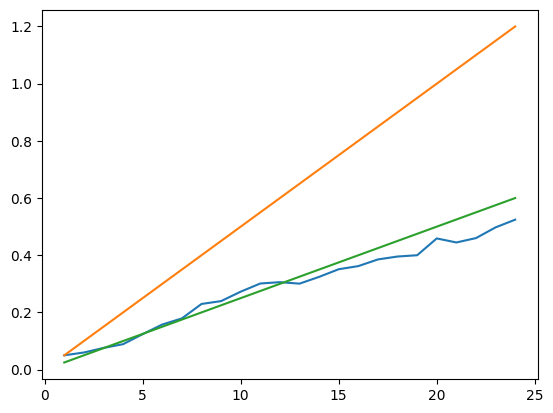

Accepted connection from <server.Client object at 0x7f7c8c1807f0>


In [102]:
plt.plot(x, [1/z for z in y1])
plt.plot(x, [1/z for z in y2])
plt.plot(x, [0.5/z for z in y2])
plt.show()

In [76]:
env.resume()
#env.reset()
for i in range(5):
    env.step((1, 0))
env.pause()

In [52]:
env.step((0,0))

(tensor([ 0.1846,  0.5015,  0.1063,  0.0645,  0.0736, -0.3445,  0.1488, -0.4067,
          0.6449]),
 -0.08402927964925766,
 False,
 False)

In [58]:
env.pause()

In [ ]:
feat = agent.policy.net(obs)
mu = agent.policy.mu_layer(feat)
log_std = agent.policy.log_std_layer(feat)
std = torch.exp(log_std)

mu, std, log_std

In [ ]:
msg = messages.RequestMessage("test", "").to_json()
msg2 = messages.RequestMessage("timeScale", messages.SingleFieldMessage(2.).to_json()).to_json()
msg3 = messages.RequestMessage("pause", messages.SingleFieldMessage(False).to_json()).to_json()
msg4 = messages.RequestMessage("reset", "").to_json()
msg5 = messages.RequestMessage("step", messages.ControllMessage(5, 5).to_json()).to_json()


In [ ]:
r = lambda d: {k:round(v, 5) for (k, v) in d.items()}

print(r(simulator._reset().velocity))
time.sleep(env.get_target_frame_duration())
print(r(simulator._step(10, 1).velocity))
for _ in range(3):
    #time.sleep(env.get_target_frame_duration())
    print(r(simulator._step(0, 1).velocity))
simulator.shutdown()
simulator.server.clients = []

In [ ]:
simulator.server.stop_server()

In [89]:
simulator.shutdown()
#simulator.server.clients = []

In [105]:
simulator.server.clients = []